In [1]:
import torch
import numpy as np
import data
import autoencoder_resnet_simple
import models
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


BATCH_SIZE = 32
EPOCHS = 100
LATENT_DIM = 512
LR = 5e-6
in_shape = 150
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

test_dataset = data.LensingDataset('index.csv','../dataset/val/')
test_dataloader = torch.utils.data.DataLoader(test_dataset,shuffle=True,batch_size=BATCH_SIZE,num_workers=15)

def get_prediction(x, model):
    model.eval() # prepares model for predicting
    probabilities = torch.softmax(model(x), dim=1)
    predicted_class = torch.argmax(probabilities, dim=1)
    return predicted_class, probabilities
    
class Model(torch.nn.Module):
    def __init__(self) -> None:
        super(Model, self).__init__()
        self.autoencoder = autoencoder_resnet_simple.AutoEncoder(dropout=0.1)
        self.informer = models.LensAutoEncoder2(in_shape=in_shape,device=device)
        self.classifier = models.Resnet_simple()
    def forward(self, x):
        k = self.autoencoder(x)
        x = self.informer(k, x)
        x = self.classifier(x)
        return x

model = Model().to(device)
model.load_state_dict(torch.load('../trained_weights/sis_autoencoder2_fine.pt'))

/home/anirudh/Documents/GSoC/DeepLense/env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


<All keys matched successfully>

In [2]:
preds, probs, ys = [], [], []
worst_case = 0
best_case = 0
mid_case = 0
extra = 0
classes = ['no','sphere','vort']
for (x,y) in test_dataloader:
    ys = ys + list(torch.argmax(y,1))
    y = y.to(device)
    x = x.float().to(device)
    
    pred, prob = get_prediction(x, model)
    preds = preds + list(pred.detach().cpu().numpy())
    probs = probs + list(prob.detach().cpu().numpy())

for i in range(len(ys)):
    if probs[i][ys[i]] == np.min(probs[i]): worst_case += 1
    elif ys[i] == preds[i]: best_case += 1
    elif probs[i][ys[i]] == sorted(probs[i])[1]: mid_case += 1
    else: extra += 1

ns_curves = []
lr_curves = []
aucs = []
for i in range(3):
    y_ = []
    probs_ = []
    for j in range(len(preds)):
        if i==ys[j] and ys[j]==preds[j]:
            y_.append(1)
        else: y_.append(0)
        probs_.append(probs[j][i])
    ns_probs = np.array([1/len(probs_) for __ in range(len(probs_))])
    ns_auc = roc_auc_score(y_, ns_probs,multi_class='ovr')
    lr_auc = roc_auc_score(y_, probs_,multi_class='ovr')
    aucs.append((ns_auc,lr_auc))

    ns_fpr, ns_tpr, _ = roc_curve(y_, np.array([0 for i in range(len(y_))]))
    lr_fpr, lr_tpr, _ = roc_curve(y_, probs_)
    ns_curves.append((ns_fpr, ns_tpr))
    lr_curves.append((lr_fpr, lr_tpr))
# plot the roc curve for the model

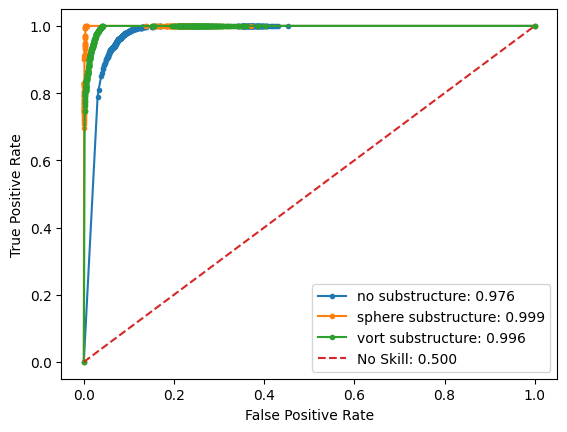

Correct identifications: 0.8493333333333334
True had least prob: 0.0516
True had 2nd highest prob: 0.09906666666666666
Sum for verification = 1.0


In [3]:
for i in range(3):
    plt.plot(lr_curves[i][0], lr_curves[i][1], marker='.', label='%s substructure: %.3f'%(classes[i],aucs[i][1]))
plt.plot(ns_curves[0][0], ns_curves[0][1], linestyle='--', label='No Skill: %.3f'%(aucs[0][0]))
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()
print("Correct identifications: %s\nTrue had least prob: %s\nTrue had 2nd highest prob: %s\nSum for verification = %s"%(best_case/len(ys),worst_case/len(ys),mid_case/len(ys),(best_case+worst_case+mid_case)/len(ys)))